# Оптимизация производственных расходов металлургического комбината

### Цель проекта

Заказчик решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.



## Примерный план работы:

1. Ознакомиться с данными и провести исследовательский анализ. Провести предобработку данных.
2. Создать признаки (features/target). Разделить выборку на обучающую и тестовую (планирую использовать кросс-валидацию, но если по каким-то причином ее провести будет невозможно, то дополнительно выделить валидационную выборку)
3. Выбрать несколько моделей (точно будет бустинг, мб еще что-то линейное), обучить их, подобрать для них оптимальные гиперпараметры (например, подбором по сетке)
4. Сравнить точность моделей на целевой метрике, выбрать оптимальную и проверить ее на тестовой выборке
5. Сделать выводы

# Шаг 1. Знакомство с данными и исследовательский анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
import plotly.figure_factory as ff
import lightgbm as lgb
import xgboost as xgb
import plotly.express as px
from functools import reduce
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from IPython.display import clear_output

Загружаем данные из файлов:

In [2]:
arc_data = pd.read_csv('/home/konstantin/datasets/final_steel/data_arc.csv')
bulk_data = pd.read_csv('/home/konstantin/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/home/konstantin/datasets/final_steel/data_bulk_time.csv')
gas_data = pd.read_csv('/home/konstantin/datasets/final_steel/data_gas.csv')
temp_data = pd.read_csv('/home/konstantin/datasets/final_steel/data_temp.csv')
wire_data = pd.read_csv('/home/konstantin/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/home/konstantin/datasets/final_steel/data_wire_time.csv')

### Данные об электродах

In [3]:
arc_data.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Столбцы имеют русские наименования, однако это не самый оптимальный вариант для работы поскольку, во-первых, они содержат пробелы, что мешает, к примеру, обращаться к столбцам через точку ("dataframe.column"), во-вторых, лишний раз заставляет переключать раскладку при написании кода. Здесь и далее будем переводить их на английский:

In [4]:
arc_data.columns = ['key', 'start_heat', 'end_heat', 'active_pow', 'reactive_pow']

In [5]:
arc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           14876 non-null  int64  
 1   start_heat    14876 non-null  object 
 2   end_heat      14876 non-null  object 
 3   active_pow    14876 non-null  float64
 4   reactive_pow  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропуски в таблице отсутствуют. Мы видим, что столбцы "начало" и "конец нагрева дугой" содержат время, однако имеют универсальный тип данных "object". Целесообразно назначить им соответствующий dtype

In [6]:
arc_data.loc[:, ['start_heat', 'end_heat']] = arc_data.loc[:, ['start_heat', 'end_heat']].astype('datetime64')

In [7]:
arc_data.describe()

,key,active_pow,reactive_pow
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Видим, что минимум реактивной мощности находится сильно ниже нуля. Реактивная мощность может быть отрицательной, однако данное значение очень похоже на выброс. Здесь нам поможет график:

<AxesSubplot:xlabel='reactive_pow'>

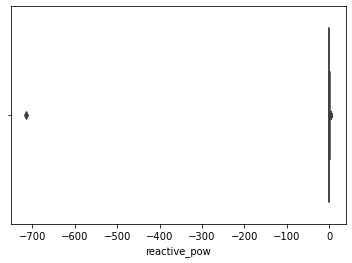

In [8]:
sns.boxplot(x=arc_data.reactive_pow)

Как видим, это классический выброс. Удалим его. Построим графики активной и реактивной мощностей без учета этого значения:

In [9]:
arc_data = arc_data.query('reactive_pow > -700')

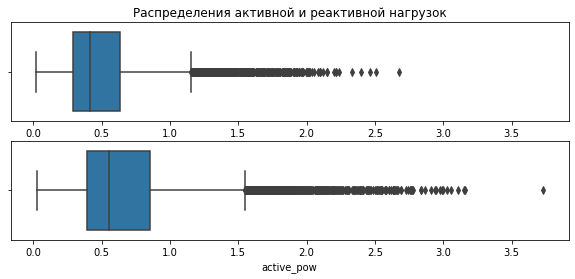

In [10]:
plt.figure(figsize=(10,4))
ax1 = plt.subplot(211)
sns.boxplot(data=arc_data, x='reactive_pow')
plt.title("Распределения активной и реактивной нагрузок")
plt.subplot(212, sharex=ax1)
sns.boxplot(data=arc_data, x='active_pow')
plt.show()

Видим, что обычно мощность электродов составляет от 0.4 до 0.8, и в обычно активная мощность немного больше реактивной, что хорошо, поскольку реактивная мощность паразитна

Создадим добавочный признак: длительность нагрева при каждой итерации

In [11]:
arc_data['duration'] = (arc_data['end_heat'] - arc_data['start_heat']).apply(lambda x: x.seconds)

In [12]:
arc_data.head()

,key,start_heat,end_heat,active_pow,reactive_pow,duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


Теперь сгруппируем данные по номеру партии и вычислим сколько циклов было затрачено на каждую из них, а также общую 
активную и реактивную затраченную мощность

In [13]:
arc_pivot = arc_data.pivot_table(index='key', values=['duration', 'active_pow', 'reactive_pow'], aggfunc=['count', 'sum'])
arc_pivot.drop(arc_pivot.columns[[0,1]], axis=1, inplace=True)

In [14]:
arc_pivot.head(10)

count        sum                      
    reactive_pow active_pow duration reactive_pow
key                                              
1              5   4.878147     1098     3.183241
2              4   3.052598      811     1.998112
3              5   2.525882      655     1.599076
4              4   3.209250      741     2.060298
5              4   3.347173      869     2.252643
6              4   3.955108      952     2.689175
7              4   2.547375      673     1.561295
8              4   3.762755      913     2.680698
9              5   2.081951      625     1.478671
10             6   2.923622      825     2.496116

Избавимся от мультииндекса и назначим столбцам более удобные названия:

In [15]:
arc_pivot.columns = ['cycles', 'sum_active', 'sum_time', 'sum_reactive']

In [16]:
arc_pivot.describe()

,cycles,sum_active,sum_time,sum_reactive
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,4.628189,3.102984,794.545115,2.317442
std,1.608866,1.397556,332.491076,1.054316
min,1.000000,0.186226,57.000000,0.158247
25%,4.000000,2.126339,571.000000,1.599018
50%,4.000000,2.990537,770.000000,2.229869
75%,6.000000,3.901147,983.000000,2.899141
max,16.000000,17.496497,4189.000000,12.587990


### Данные о подаче сыпучих материалов

Перейдем к данным о подаче сыпучих материалов

In [17]:
bulk_data.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Меняем названия столбцов:

In [18]:
bulk_data.columns = [re.sub(' ', '_', column).lower() for column in bulk_data.columns]

In [19]:
bulk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Заметим, что в данных очень много пропусков. В данном случае это скорее всего означает, что конкретная добавка не использовался в конкретной партии, что дает нам основания заполнить их нулями

In [20]:
bulk_data.fillna(0, inplace=True)

Временн*ы*е таблицы (bulk_time, wire_time) вообще, на мой взляд, использовать в модели необязательно, их рассматривать не будем

### Данные о продувке сплава газом

In [21]:
gas_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [22]:
gas_data.rename({'Газ 1': 'gas'}, axis=1, inplace=True)

In [23]:
gas_data.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [24]:
gas_data.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


### Данные о проволочных материалах

Рассмотрим таблицу с данными:

In [25]:
wire_data.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
wire_data.columns = [re.sub(' ', '_', column).lower() for column in wire_data.columns]

In [27]:
wire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В отношении количества и природы пропусков данные о проволочных матриалах не отличаются от сыпучих, поэтому для их заполнения применим тот же подход:

In [28]:
wire_data.fillna(0, inplace=True)

### Данные о результатах измерения температуры

In [29]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Переименуем колонки, а столбцец со временем сконвертируем в соответствующий формат

In [30]:
temp_data.columns = ['key', 'time', 'temp']
temp_data.loc[:, 'time'] = pd.to_datetime(temp_data.loc[:, 'time'])

In [31]:
temp_data.head()

,key,time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


В данных присутствуют пропуски, в том числе отсутствует измеренная температура в последнем цикле у многих партий, например:

In [32]:
temp_data[temp_data.key == 2500]

,key,time,temp
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN


Эти данные не получится использовать для обучения модели, чуть ниже мы увидим, почему. Пока просто сгруппируем данные по партиям, чтобы получить первое и последнее измерение температуры для каждой из них

In [33]:
batch_last_temp = temp_data.groupby('key').last()
batch_first_temp = temp_data.groupby('key').first()
batch_last_temp = batch_last_temp.reset_index()
batch_first_temp = batch_first_temp.reset_index()

Объединим получившиеся таблицы в одну

In [34]:
batch_temp = pd.merge(batch_first_temp, batch_last_temp, on='key', suffixes=['_first', '_last'])

In [35]:
batch_temp.head()

,key,time_first,temp_first,time_last,temp_last
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


Построим график зависимости между начальной и конечной температурой (__*добавлено после обучения прототипа*__)

In [ ]:
batch_temp = batch_temp[1300 <= batch_temp['temp_first']] # drop extreeeme outliers
fig = px.scatter(batch_temp, x='temp_first', y='temp_last', width=500, height=500)
fig.update_xaxes(range=[1500, 1700])
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )

Наблюдаем кучное скопление точек по центру с некоторым количеством нестандартных значений от 1650 градусов и выше, а также явно выделяющуюся прямую от левого нижнего угла к правому верхнему. При этом при наведении на точки (да и "на глаз") легко заметить, что данная линия образована из значений, для которых начальная температура равна конечной.
Даже при беглом взгляде на график видно, что эти всоедствие этого температуры достаточно сильно коррелируют между собой. Изначально я не учел в модели начальную температуру вовсе, и MAE составило около 9-10. После включения же в модель этого признака метрика улучшилась до ~8.5, при этом анализ значимости признаков показал, что именно начальная температура сильнее всего влияла на предсказания модели. Таким образом, это важный признак, и его нужно учитывать.

Однако значение целевой метрики было далеко от требуемого заказчиком. В чем же дело? Возможно, выбросы мешают обучению модели. Для проверки этой гипотезы стал отбрасывать некоторый процент самых больших и самых маленьких значений признаков. Чем больше отбрасывал - тем лучше работала модель. При дальнейшем исследовании выяснил, что проблема только в одном признаке - начальной температуре стали. Мы уже знаем, что признак очень важный и положительно влияет на точность предсказаний модели. Тем не менее что-то в нем мешает обучению. Для выяснения причин необходимо посмотреть, как эти признаки коррелируют друг с другом. Так мы выходим на график выше.

Откуда же берутся точки с одинаковыми значениями начальной и конечной температур? Легко показать, что в таких строках другие признаки ненулевые. Т.е. для этих наблюдений и примеси добавляли, и производили нагрев электродами, и при этом значение температуры не изменилось ни на тысячную долю градуса. Такое представить практически невозможно - даже если не делать совсем ничего, температура поменяется. И уж точно не могут совпасть температуры у многих наблюдений. А их довольно много - покажем это:

In [37]:
sum(batch_temp['temp_first'] == batch_temp['temp_last'])

782

Во многих партиях пропущено значение последнего замера температуры. Изначально была мысль заполнить их через forward fill, однако позже я отказался от этой идеи, поскольку, во-первых, это не улучшало качество предсказаний прототипа модели, во-вторых, такой подход рождает еще больше значений из "прямой линии" на графике выше, от которых, как мы увидим далее, необходимо избавиться, наконец, в-третьих, значение последнего измерения температуры является целевым признаком и заполнять его какими-либо расчетными значениями было бы в корне неверно.

Если совпадающие начальные и конечные значения температуры получены не путем наблюдений, то они получились "искусственно" - при обработке данных. В нашем случае их появления обусловлено применением метода groupby. Посмотрим, сколько существует групп, в которых всего одно значение - в таких группах единственная температура является одновременно и первой, и последной замеренной:

In [38]:
sum(temp_data.groupby('key').count()['temp'] == 1)

741

Т.е. их количество почти совпадает с количеством точек на прямой "идеальной корреляции" с графика выше. Практический опыт показал, что от них необходимо избавиться - фактически, для них отсутствует целевой признак. В нашем случае, чтобы иметь возможность отличить его от нецелевого (начальной температуры), необходимо иметь как минимум два наблюдения в группе (партии). Поэтому нам придется отбросить достаточно большое количество данных.

In [39]:
batch_temp = batch_temp[batch_temp['temp_first'] != batch_temp['temp_last']]

# Шаг 2. Подготовка данных для обучения

Исходя из имеющихся данных, предположим, что на финальную температуру могут влиять следующие параметры:
1. Общая затраченная мощность (без учета количества циклов) - чем больше энергии затратили, тем больше нагрев
2. Начальная температура стали
3. Количество затраченных циклов
4. Общее количество добавок

Как мы видели выше, многие виды добавок встречаются очень редко. Представляется хорошей стратегией либо вообще не брать такие добавки, либо попробовать L1-регуляризацию, которая, как известно, предпочитает sparse-решения. Реализуем второй вариант, поскольку модели машинного обучения, как правило, сами неплохо справляются с выделением важных признаков, а регуляризацию удобно включить в параметры перебора по сетке (GridSearch).

Сгруппируем данные по партиям, чтобы получить общую таблицу признаков

Создаем датафрейм. Поскольку время нас не интересует, избавимся от этих данных, и возьмем только температуру:

In [40]:
steel_data = batch_temp.drop(['time_first', 'time_last'], axis=1)

Группируем данные по добавочным материалам, суммируем по каждой партии:

In [41]:
bulk_summed = bulk_data.groupby('key').sum()
wire_summed = wire_data.groupby('key').sum()

Сливаем все таблицы в одну:

In [42]:
dfs = [steel_data, bulk_summed, wire_summed, gas_data, arc_pivot]
steel_data = reduce(lambda left, right: pd.merge(left, right, on='key'), dfs)

У нас есть столбцы, где абсолютно все значения нулевые. На финальный результат это, может, и не влияет, но увеличивает время обучения. Стоит избаваться от них:

In [43]:
zeros = [column for column in steel_data.columns if not np.any(steel_data[column])]
steel_data = steel_data.drop(zeros, axis=1)

Теперь выделим целевой признак и поделим данные на выборки

In [44]:
target = steel_data['temp_last']
features = steel_data.drop(['temp_last', 'key'], axis=1)

Проверим признаки на мультиколлинеарность

In [45]:
feat_corr = features.corr()

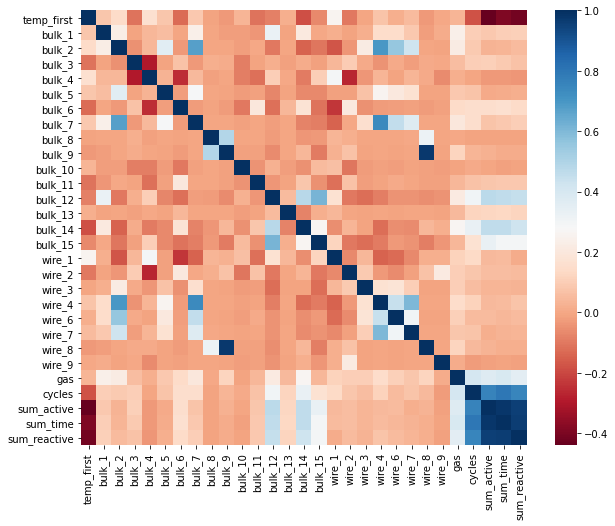

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(feat_corr, cmap='RdBu', cbar=True)
plt.show()

Видим сильную зависимость в паре *bulk_9* - *wire_8*, а также в сгенерированных нами признаках = количестве циклах и сумме активной/реактивной мощностей и затраченного времени

Убираем 3 таких признака (опытным путем установлено, что удаление других ухудшает качество модели)

In [47]:
features = features.drop(['bulk_9', 'sum_reactive', 'sum_time'], axis=1)

Также в ходе обучения моделей и анализа используемых ими признаков, был выявлен ряд фич с крайне низкой (строго говоря, нулевой) значимостью. Их мы тоже убираем для ускорения обучения. При этом важно отметить, что метрика не только не просела, но и немного улучшилась (после удаления признаков в *предыдущей* ячейке))

In [48]:
features = features.drop(['bulk_2', 'bulk_7', 'bulk_8', 'bulk_13',
                         'wire_4', 'wire_7', 'wire_8', 'wire_9'], axis=1)

Теперь поделим выборку на обучающую и тестовую

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=146)

Проверяем размерность

In [50]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1831, 18) (458, 18) (1831,) (458,)


Данные подготовлены, можно приступать к обучению

# Шаг 3. Обучение и выбор модели

Рассмотрим несколько популярных библиотек машинного обучения. Для обучения нейронных сетей у нас недостаточно данных, к тому же вряд ли мы имеем дело с неявными зависимостями между входными и выходными данными, поэтому ограничимся линейными моделями и бустингом.

#### Модель-заглушка

Начнем с модели-заглушки, это позволит сразу проверять используемые модели на адекватность

In [51]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dum_pred = dummy.predict(X_test)
mean_absolute_error(y_test, dum_pred)

8.479457380055758

#### Линейная регрессия

In [52]:
lin1 = LinearRegression()
cross_val_score(lin1, X_train, y_train, scoring='neg_mean_absolute_error').mean()

-6.107969329056925

In [53]:
lin2 = Lasso()
param_grid = {'alpha': np.arange(0.01, 1, 0.05)}
las_cv = GridSearchCV(lin2, param_grid, cv=5, scoring='neg_mean_absolute_error')

In [54]:
las_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96])},
             scoring='neg_mean_absolute_error')

In [55]:
las_cv.best_score_

-6.107828992289667

In [56]:
las_cv.best_params_

{'alpha': 0.060000000000000005}

#### LightGBM

In [57]:
lgb_model = lgb.LGBMRegressor()
param_grid = {
    'learning_rate': np.arange(0.01, 0.1, 0.02),
    'max_depth': np.arange(1, 8, 2),
    'verbose': [-1],
    'num_leaves': [5, 10, 20],
    'n_estimators': [50, 100, 200],
    'reg_lambda': np.arange(0, 0.4, 0.1)
}

cv = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error')

In [58]:
%%time
cv.fit(X_train, y_train)

CPU times: user 6min 17s, sys: 22 s, total: 6min 39s
Wall time: 1min 43s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09]),
                         'max_depth': array([1, 3, 5, 7]),
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [5, 10, 20],
                         'reg_lambda': array([0. , 0.1, 0.2, 0.3]),
                         'verbose': [-1]},
             scoring='neg_mean_absolute_error')

In [59]:
cv.best_score_

-5.863273839486268

In [60]:
cv.best_params_

{'learning_rate': 0.06999999999999999,
 'max_depth': 7,
 'n_estimators': 100,
 'num_leaves': 20,
 'reg_lambda': 0.0,
 'verbose': -1}

In [61]:
cv.best_estimator_.feature_importances_

array([312,  45,  57,  50,  14,  72,   3,  12,  77, 154,  90, 168,  92,
        17,   6, 177,  71, 326], dtype=int32)

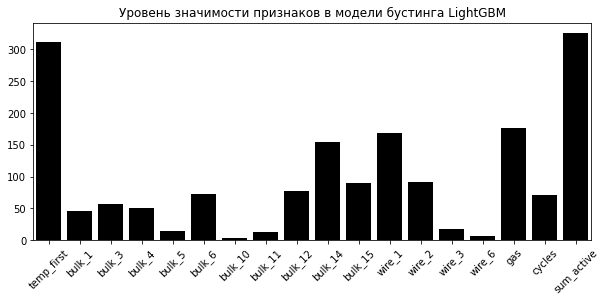

In [62]:
plt.figure(figsize=(10,4))
plt.title('Уровень значимости признаков в модели бустинга LightGBM')
feat_imp = sns.barplot(x=features.columns, y=cv.best_estimator_.feature_importances_, color='black')
for item in feat_imp.get_xticklabels():
    item.set_rotation(45)
plt.show()

**Вывод**: модель опирается в первую очередь на потребленную мощность и начальную температуру, но также учитывает уровень многих добавочных материалов

#### CatBoost

In [63]:
%%time
cat_model = CatBoostRegressor(loss_function='MAE')
cats_gs = cat_model.grid_search({'learning_rate': np.arange(0.01, 0.1, 0.02),
                                 'depth': np.arange(2, 9, 2), 'n_estimators': [50, 150, 300, 500]}, X_train, y_train)


bestTest = 963.7521124
bestIteration = 49

0:	loss: 963.7521124	best: 963.7521124 (0)	total: 93.2ms	remaining: 7.36s

bestTest = 347.6242475
bestIteration = 49

1:	loss: 347.6242475	best: 347.6242475 (1)	total: 124ms	remaining: 4.82s

bestTest = 122.9334105
bestIteration = 49

2:	loss: 122.9334105	best: 122.9334105 (2)	total: 145ms	remaining: 3.71s

bestTest = 42.72517114
bestIteration = 49

3:	loss: 42.7251711	best: 42.7251711 (3)	total: 166ms	remaining: 3.15s

bestTest = 15.04164257
bestIteration = 49

4:	loss: 15.0416426	best: 15.0416426 (4)	total: 186ms	remaining: 2.78s

bestTest = 352.9627578
bestIteration = 149

5:	loss: 352.9627578	best: 15.0416426 (4)	total: 244ms	remaining: 3s

bestTest = 17.08432363
bestIteration = 149

6:	loss: 17.0843236	best: 15.0416426 (4)	total: 308ms	remaining: 3.21s

bestTest = 6.38843589
bestIteration = 149

7:	loss: 6.3884359	best: 6.3884359 (7)	total: 373ms	remaining: 3.36s

bestTest = 5.865770485
bestIteration = 149

8:	loss: 5.8657705	best: 5.865


bestTest = 15.69764752
bestIteration = 297

71:	loss: 15.6976475	best: 5.7037667 (19)	total: 18.6s	remaining: 2.06s

bestTest = 16.48396788
bestIteration = 238

72:	loss: 16.4839679	best: 5.7037667 (19)	total: 19.7s	remaining: 1.89s

bestTest = 17.26481474
bestIteration = 251

73:	loss: 17.2648147	best: 5.7037667 (19)	total: 21s	remaining: 1.7s

bestTest = 17.76458967
bestIteration = 162

74:	loss: 17.7645897	best: 5.7037667 (19)	total: 21.9s	remaining: 1.46s

bestTest = 22.5356101
bestIteration = 499

75:	loss: 22.5356101	best: 5.7037667 (19)	total: 23.4s	remaining: 1.23s

bestTest = 15.5923385
bestIteration = 476

76:	loss: 15.5923385	best: 5.7037667 (19)	total: 25s	remaining: 974ms

bestTest = 16.47757382
bestIteration = 477

77:	loss: 16.4775738	best: 5.7037667 (19)	total: 26.7s	remaining: 684ms

bestTest = 17.26481474
bestIteration = 251

78:	loss: 17.2648147	best: 5.7037667 (19)	total: 28.4s	remaining: 360ms

bestTest = 17.76458967
bestIteration = 162

79:	loss: 17.7645897	best:

In [64]:
print(cats_gs['params'])

{'depth': 2, 'iterations': 500, 'learning_rate': 0.08999999999999998}


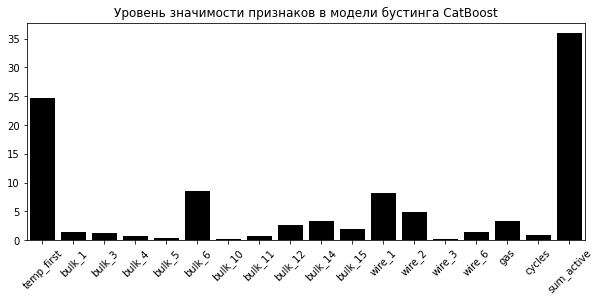

In [65]:
plt.figure(figsize=(10,4))
plt.title('Уровень значимости признаков в модели бустинга CatBoost')
feat_imp_cat = sns.barplot(x=features.columns, y=cat_model.feature_importances_, color='black')
for item in feat_imp_cat.get_xticklabels():
    item.set_rotation(45)
plt.show()

**Вывод**: данная модель опирается в большей части на сумму потребленной мощности и начальную температуру стали, а признаки добавляемых материалов использует лишь выборочно, при этом некоторые из них практически не оказывают влияния на итоговый результат

#### XGBoost

In [66]:
xmodel = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=8)
x_param_grid = {
    'learning_rate': np.arange(0.01, 0.18, 0.05),
    'max_depth': np.arange(2, 8, 2),
    'n_estimators': [50, 150, 300],
    'reg_alpha': [0, 0.1, 0.3]
}

xcv = GridSearchCV(xmodel, x_param_grid, cv=5, scoring='neg_mean_absolute_error')

In [67]:
%%time
xcv.fit(X_train, y_train)

CPU times: user 2min 29s, sys: 3min 19s, total: 5min 49s
Wall time: 1min 32s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_paramet

In [68]:
xcv.best_score_

-5.8449721933566705

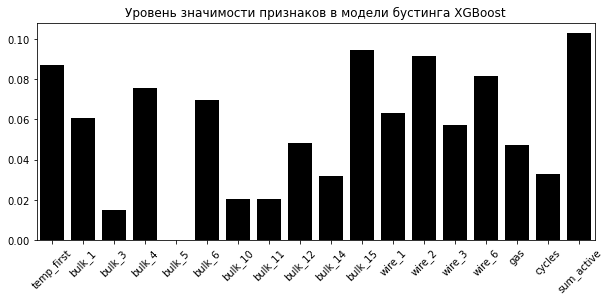

In [69]:
plt.figure(figsize=(10,4))
plt.title('Уровень значимости признаков в модели бустинга XGBoost')
feat_imp_xgb = sns.barplot(x=features.columns, y=xcv.best_estimator_.feature_importances_, color='black')
for item in feat_imp_xgb.get_xticklabels():
    item.set_rotation(45)
plt.show()

**Вывод**: по сравнению с предыдущими кандидатами данная модель гораздо более равномерно использует признаковое пространство, используя большинство информации о добавкам и присваивая им гораздо большие относительные веса

# Шаг 4. Анализ моделей

Обучим модели с оптимальными гиперпараметрами и сравним результаты на тестовой выборке

In [70]:
results = {}

#### Линейная регрессия

In [71]:
las_final = Lasso(alpha=0.06)
las_final.fit(X_train, y_train)
start_pred = datetime.datetime.now()
las_pred = las_final.predict(X_test)
end_pred = datetime.datetime.now()
las_score = mean_absolute_error(y_test, las_pred)
results['Lasso'] = [(end_pred-start_pred).microseconds//1000, np.round(las_score, decimals=2)]

#### LightGBM

In [72]:
lgb_final = lgb.LGBMRegressor(**cv.best_params_)
lgb_final.fit(X_train, y_train)
start_pred = datetime.datetime.now()
lgb_pred = lgb_final.predict(X_test)
end_pred = datetime.datetime.now()
lgb_score = mean_absolute_error(y_test, lgb_pred)
results['LightGBM'] = [(end_pred-start_pred).microseconds//1000, np.round(lgb_score, decimals=2)]

#### CatBoost

In [73]:
cat_final = CatBoostRegressor(**cats_gs['params'])
cat_final.fit(X_train, y_train)
start_pred = datetime.datetime.now()
cat_pred = cat_final.predict(X_test)
end_pred = datetime.datetime.now()
cat_score = mean_absolute_error(y_test, cat_pred)
results['CatBoost'] = [(end_pred-start_pred).microseconds//1000, np.round(cat_score, decimals=2)]
clear_output()

#### XGBoost

In [74]:
xgb_final = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_jobs=8, **xcv.best_params_)
xgb_final.fit(X_train, y_train)
start_pred = datetime.datetime.now()
xgb_pred = xgb_final.predict(X_test)
end_pred = datetime.datetime.now()
xgb_score = mean_absolute_error(y_test, xgb_pred)
results['XGBoost'] = [(end_pred-start_pred).microseconds//1000, np.round(xgb_score, decimals=2)]

### Итоговая таблица

In [75]:
pd.DataFrame(results, index=['Время предсказания, мс', 'MAE (тест)'])

,Lasso,LightGBM,CatBoost,XGBoost
"Время предсказания, мс",2.00,2.00,3.00,2.00
MAE (тест),6.08,5.96,5.92,6.06


# Отчет о проделанной работе

**Краткий итог**: Мы разработали модель для предсказания температуры стали. Наилучший результат показала модель градиентного бустинга CatBoost. LightGBM и CatBoost полностью удовлетворяет требованиям заказчика по точности, но XGBoost имеет чуть меньшее время предсказания. Стоит уточнить у заказчика, насколько критично время предсказания (возможно, к примеру, на принятие решения есть буквально доли секунды, когда заливают ковш), в таком случае рекомендовать будем модель XGBoost, поскольку она лишь немного уступает по качеству "соперникам". В ином случае - CatBoost или LightGBM.

Стоит также обратить внимание заказчика на то, что финальная температура в первую очередь зависит от температуры начальной, в то время как некоторые добавки (сыпучие под №№ 2,7,8,13 и проволочные под №№ 4,7,8,9) имеют минимальное (даже нулевое) влияние на результат. Возможно, это поспособствует в принятии решения об оптимизации процесса обработки.

**Все ли пункты плана были выполнены**: Да. Мы провели исследовательский анализ и предобработку данных, создали признаки, поделили выборку на обучающую и тестовую, затем обучили несколько моделей и выбрали наиболее оптимальные

**Какие трудности возникли при решении задачи**: Не сразу удалось выделить оптимальные признаки. 

При первом обучении прототипа я не учел начальную температуру, как стало понятно в дальнейшем, именно она является признаком, наиболее сильно влияющим на признак целевой - конечную температуру. Однако после добавления начальной температуры в модель качество последней было весьма посредственным - MAE ~8-9. Это совершенно неприемлемо, поскольку позднее даже заглушка показала 8.5, то есть модель не проходила проверку на адекватность. При этом анализ значимости используемых ею признаков показал, что именно начальная температура сильнее всего влияла на предсказания модели. Таким образом, это важный признак, и его нужно учитывать. Я предположил, что обучению модели мешают какие-то выбросы в данных. 

Для проверки этой гипотезы стал отбрасывать некоторый процент самых больших и самых маленьких значений признаков. Чем больше отбрасывал - тем лучше работала модель. При дальнейшем исследовании выяснил, что проблема только в одном признаке - как раз начальной температуре стали. Как писал чуть выше, признак этот очень важный и положительно влияет на точность предсказаний модели. Тем не менее что-то в нем мешало обучению. Для выяснения причин было необходимо посмотреть, как начальная и конечная температуры коррелируют друг с другом. Я построил график их зависимости. График (он есть в разделе *Данные о результатах измерения температуры*) представлял собой скопление точек по центру с явно выделяющейся прямой от левого нижнего угла к правому верхнему. Эти точки были образованы из значений, для которых начальная температура равна конечной. Вследствие этого температуры достаточно сильно коррелировали между собой. 

Откуда же взядись точки с одинаковыми значениями начальной и конечной температур? Беглый анализ показал, что в таких строках другие признаки ненулевые. Т.е. для этих партий и примеси добавляли, и производили нагрев электродами, и при этом значение температуры не изменилось ни на тысячную долю градуса. Такое представить практически невозможно - даже если не делать совсем ничего, температура поменяется. И уж точно не могут совпасть температуры у многих наблюдений. А их оказалось довольно много - несколько сотен.

Во многих партиях было пропущено значение последнего замера температуры. Изначально была мысль заполнить их через forward fill, однако позже я отказался от этой идеи, поскольку, во-первых, это не улучшало качество предсказаний прототипа модели, во-вторых, такой подход рождает еще больше наблюдений с совпадающими температурами, наконец, в-третьих, значение последнего измерения температуры является целевым признаком и заполнять его какими-либо расчетными значениями было бы в корне неверно.

Если совпадающие начальные и конечные значения температуры получены не путем наблюдений, то они получились "искусственно" - при обработке данных. В нашем случае их появление было обусловлено применением метода groupby. Дальнейший анализ показал, что количество групп (партий), в которых всего одно значение (в таких группах единственная температура является одновременно и первой, и последной замеренной), почти совпадает с количеством точек на прямой "идеальной корреляции" на графике зависимостей между признаками. Фактически, для таких партий отсутствовал целевой признак, а чтобы иметь возможность отличить его от нецелевого (начальной температуры), необходимо иметь как минимум два наблюдения в группе (партии). Поэтому пришлось отбросить достаточно большое количество данных.

**Какие ключевые шаги в решении задачи выделили**: По моему мнению, наиболее важный этап в решении данной задачи - это подготовка признаков. Необходимо не только сгруппировать признаки по партиям, но и учесть такие моменты, как в предыдущем пункте - одного измерения температуры недостаточно для включения конкретного наблюдения в модель, а также учесть мультиколлинеарность факторов. Еще можно отменить такой момент: многие из добавляемых материалов (сыпчатых и проволочных) имеют минимальное, иногда нулевое влияние на модель. Несмотря на то, что данные признаки могут не оказать влияния на непосредственное качество модели, избавившись от них, мы уменьшим время обучения, а кроме того, такая информация может быть полезна заказчику при оптимизации рабочих процессов (к примеру, решить, какие материалы можно исключить из процесса)

**Итоговая модель и её качество**: CatBoost, **MAE=5.92**